# Emotions From Images:  Data Processing

Using images representing "happy" or "sad" facial expressions.

In [1]:
import os
from PIL import ( Image, ImageOps )
import numpy as np
import pandas as pd
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline

## Helper functions
Create the flat file of images, labeling as we go and also augmenting the image data

In [2]:
def normalize(arr):
    """
    Linear normalization
    http://en.wikipedia.org/wiki/Normalization_%28image_processing%29
    """
    arr = arr.astype('float')
    minval = arr.min()
    maxval = arr.max()
    if minval != maxval:
        arr -= minval
        arr *= (255.0/(maxval-minval))
    return arr

A function to convert flat file to CNTK text format needed by the framework

In [3]:
def savetxt(filename, X_input, y_input, num_labels):
    with open(filename, 'w') as f:
        labels = list(map(' '.join, np.eye(num_labels, dtype=np.uint).astype(str)))
        for i in range(X_input.shape[0]):
            row_str = np.array(X_input[i, :]).astype(int).astype(str)
            label_str = y_input[i]
            feature_str = ' '.join(row_str)
            f.write('|labels {} |features {}\n'.format(label_str, feature_str))

## FER Faces Data

This data comes via a Kaggle competition on facial expressions found [here](https://www.kaggle.com/c/challenges-in-representation-learning-facial-expression-recognition-challenge/data).

The data consists of 48x48 pixel grayscale images of faces. The faces have been automatically registered so that the face is more or less centered and occupies about the same amount of space in each image. The task is to categorize each face based on the emotion shown in the facial expression in to one of seven categories (0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral).

### Read and process data

Read in Kaggle data (from our download and here in the "/data/fer2013" folder) and output the "happy" or "sad" normalized images to an intermediate file with the label as the first element in a row:

In [4]:
outf = open('/data/emotions_image_data_fer.csv', 'w')
labels = list(map(' '.join, np.eye(2, dtype=np.uint).astype(str)))
labeldict = {'3': 0, '4': 1}

with open('/data/fer2013/fer2013.csv', 'r') as f:
    lines = f.readlines()
    for line in lines:
        splcomma = line.split(',')
        emotion = splcomma[0].strip()
        # Grab only happy or sad
        if emotion == '3' or emotion == '4':
            img = splcomma[1].split(' ')
            arry = normalize(np.asarray(img).reshape(-1))
            # Create the label string ('0 1' or '1 0' for happy or sad)
            label_str = labels[labeldict[emotion]]
            outf.write(str(label_str) + ','+ ','.join([str(v) for v in arry]) + '\n')
outf.close()

### Save data into CNTK format
Read data back in and use scikit-learn to split into training and test datasets

In [5]:
df = pd.read_csv('/data/emotions_image_data_fer2.csv', header=None)
df = shuffle(df)
X = np.array(df.iloc[:, 1:])
y = np.array(df.iloc[:, 0])
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                   test_size=0.1,
                                                   random_state=42,
                                                   stratify=y)
savetxt('/data/Emotions-48x48-train_cntk_text.txt', X_train, y_train, num_labels=2)
savetxt('/data/Emotions-48x48-test_cntk_text.txt', X_test, y_test, num_labels=2)
print(X_train.shape, X_test.shape)

(13559, 2304) (1507, 2304)


## Plot some examples

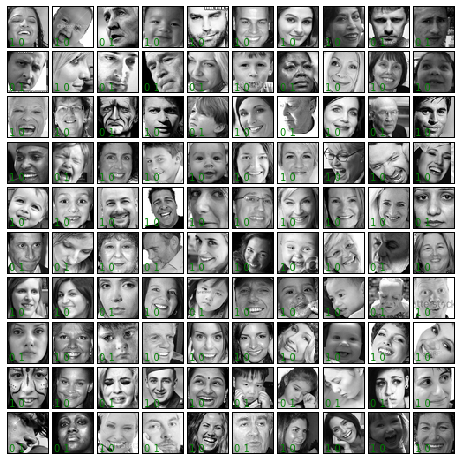

In [6]:
fig, axes = plt.subplots(10, 10, figsize=(8, 8),
                         subplot_kw={'xticks':[], 'yticks':[]},
                         gridspec_kw=dict(hspace=0.1, wspace=0.1))

for i, ax in enumerate(axes.flat):
    ax.imshow(X_train[i, :].reshape(48, 48)/255,
              interpolation='nearest', cmap='gray')
    ax.text(0.05, 0.05, str(y_train[i]),
            transform=ax.transAxes, color='green')

Happy face


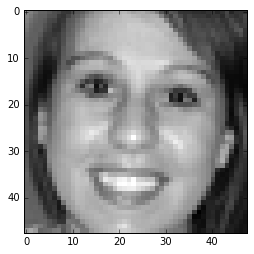

In [7]:
# imshow needs data in [0, 1] range
# Show a happy face
for i in range(len(y_test)):
    if y_test[i] == '1 0':
        plt.imshow(X_test[i, :].reshape(48, 48)/255,
                  interpolation='nearest', cmap='gray')
        print('Happy face')
        break

Sad face


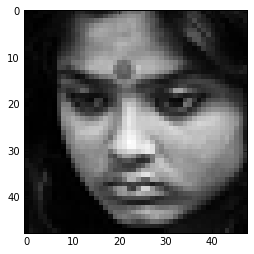

In [8]:
# Show a sad face
for i in range(len(y_test)):
    if y_test[i] == '0 1':
        plt.imshow(X_test[i, :].reshape(48, 48)/255,
                  interpolation='nearest', cmap='gray')
        print('Sad face')
        break

## Bring your own new data for testing

Place your own images here in the place of the given image data file names and use the PIL ImageOps module to get into the right format for compatibility with the training/test datasets from above.

In [67]:
X = np.zeros(2*48*48).reshape(2, 48*48)

img1 = Image.open('/data/my_happy_sad_downloads/happy/aa6ef8f7a8f88d1a3beaf9669f057f62.jpg')
label_str1 = '1 0' # happy
# The next two lines are to pad this image and then crop it to 1:1 aspect ratio
img1 = ImageOps.expand(img1, border=25, fill='gray')
img1 = ImageOps.fit(img1, size=(48, 48))
img1 = ImageOps.grayscale(img1)
# Normalize a single image represented as a flattened array of 
#   48x48 columns and one row
arry1 = normalize(np.asarray(img1, dtype='int32').flatten().reshape(1, -1))

img2 = Image.open('/data/my_happy_sad_downloads/sad/bach-flower-remedies-1274x800-420x390.jpg')
label_str2 = '0 1' # sad
# The next two lines are to pad this image and then crop it to 1:1 aspect ratio
img2 = ImageOps.expand(img2, border=25, fill='gray')
img2 = ImageOps.fit(img2, size=(48, 48))
img2 = ImageOps.grayscale(img2)
# Normalize a single image represented as a flattened array of 
#   48x48 columns and one row
arry2 = normalize(np.asarray(img2, dtype='int32').flatten().reshape(1, -1))

# Combine the two test images
X[0, :] = arry1
X[1, :] = arry2

# Save this data in cntk-compatible format
savetxt('/data/harris_48x48_cntk_text.txt', X, [label_str1, label_str2], num_labels=2)

Happy face


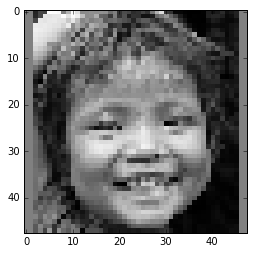

In [68]:
plt.imshow(arry1.reshape(48, 48)/255,
                  interpolation='nearest', cmap='gray')
print('Happy face')

Sad face


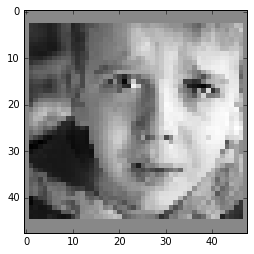

In [69]:
plt.imshow(arry2.reshape(48, 48)/255,
                  interpolation='nearest', cmap='gray')
print('Sad face')

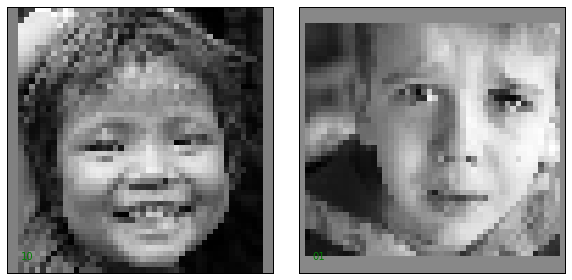

In [70]:
my_test_labels = ['10', '01']

fig, axes = plt.subplots(1, 2, figsize=(10, 10),
                         subplot_kw={'xticks':[], 'yticks':[]},
                         gridspec_kw=dict(hspace=0.1, wspace=0.1))

for i, ax in enumerate(axes.flat):
    ax.imshow(X[i, :].reshape(48, 48)/255,
              interpolation='nearest', cmap='gray')
    ax.text(0.05, 0.05, str(my_test_labels[i]),
            transform=ax.transAxes, color='green')